In [10]:
import sys
sys.path.insert(0, './../') 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torchvision import datasets, transforms

import numpy as np
from matplotlib import pyplot as plt
import foolbox 
from foolbox import attacks as fa

# own modules
from abs_models import utils as u
from abs_models import models as mz
from abs_models import attack_utils as au

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
model = mz.get_VAE(n_iter=50)              # ABS do n_iter=1 for speedup (but ess accurate)
# model = mz.get_VAE(binary=True)           # ABS with scaling and binaryzation
# model = mz.get_binary_CNN()               # Binary CNN
# model = mz.get_CNN()                      # Vanilla CNN
# model = mz.get_NearestNeighbor()          # Nearest Neighbor, "nearest L2 dist to each class"=logits
# model = mz.get_madry()                    # Robust network from Madry et al. in tf

ABS model
model loaded


In [12]:
# code is agnostic of pytorch/ tensorflow model --> foolbox model
if model.code_base == 'tensorflow':
    fmodel = foolbox.models.TensorFlowModel(model.x_input, model.pre_softmax, (0., 1.),
                                            channel_axis=3)
elif model.code_base == 'pytorch':
    model.eval()
    fmodel = foolbox.models.PyTorchModel(model,   # return logits in shape (bs, n_classes)
                                         bounds=(0., 1.), num_classes=10,
                                         device=u.dev())
else:
    print('not implemented')

In [13]:
# test model 
b, l = u.get_batch(bs=1000)  # returns random batch as np.array
pred_label = np.argmax(fmodel.batch_predictions(b), axis=1)
print('score', float(np.sum(pred_label == l)) / b.shape[0])

setting random seed


/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


done creating samples
score 0.995


# Decision based attacks
Note that this is only demo code. All experiments were optimized to our compute architecture. 

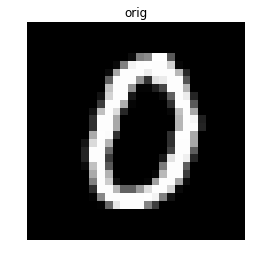

/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
att = fa.PointwiseAttack(fmodel)
metric = foolbox.distances.L0
criterion = foolbox.criteria.Misclassification()

b, l = u.get_batch(bs=1)  # returns random batch
plt.imshow(b[0, 0], cmap='gray')
plt.title('orig')
plt.axis('off')
plt.show()

# Estimate gradients from scores
if not model.has_grad: 
    GE = foolbox.gradient_estimators.CoordinateWiseGradientEstimator(0.1)
    fmodel = foolbox.models.ModelWithEstimatedGradients(fmodel, GE)

# gernate Adversarial
a = foolbox.adversarial.Adversarial(fmodel, criterion, b[0], l[0], distance=metric)
att(a)   


print('pred', np.argmax(fmodel.predictions(a.image)))
if a.image is not None:   # attack was successful
    plt.imshow(a.image[0], cmap='gray')
    plt.title('adv')
    plt.axis('off')
    plt.show()

# get Trash Adversarials

In [6]:
from foolbox.gradient_estimators import CoordinateWiseGradientEstimator as CWGE

In [7]:
a = np.random.random((1, 28, 28)).astype(np.float32)
a_helper = torch.tensor(torch.from_numpy(a.copy()), requires_grad=True)
fixed_class = 1
GE = CWGE(1.)

In [8]:
opti = torch.optim.SGD([a_helper], lr=1, momentum=0.95)

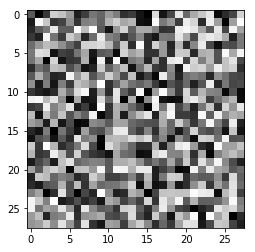

0


/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


probs 0.100 class 2


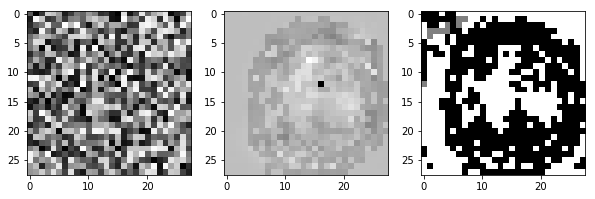

10
20
30
40
50
60


KeyboardInterrupt: 

In [9]:
confidence_level = model.confidence_level    # abs 0.0000031, CNN 1439000, madry 60, 1-NN 0.000000000004
logits_scale = model.logit_scale                     # ABS 430, madry 1, CNN 1, 1-NN 5

a_orig = a
plt.imshow(u.t2n(a[0]), cmap='gray')
plt.show()

for i in range(10000):
    if i % 10 == 0:
        print(i)
    logits = fmodel.predictions(a)
    probs = u.t2n(u.confidence_softmax(logits_scale*torch.from_numpy(logits[None, :]), dim=1, 
                  const=confidence_level))[0]
    pred_class = np.argmax(u.t2n(logits).squeeze())
    
    if probs[fixed_class]>= 0.9:
        break   
    grads = GE(fmodel.batch_predictions, a, fixed_class, (0,1))

    a = au.update_distal_adv(a, a_helper, grads, opti)
    if i % 1000 == 0:
        print(f'probs {probs[pred_class]:.3f} class', pred_class)
        fig, ax = plt.subplots(1,3, squeeze=False, figsize=(10, 4))
        ax[0, 0].imshow(u.t2n(a[0]), cmap='gray')
        ax[0, 1].imshow(u.t2n(grads[0]), cmap='gray')
        ax[0, 2].imshow(np.sign(grads[0]), cmap='gray')
        plt.show()
plt.imshow(u.t2n(a[0]), cmap='gray')
plt.show()

# Latent Descent Attack

In [ ]:
# only for abs
att = au.LineSearchAttack(model)   # BinaryLineSearchAttack
b, l = u.get_batch(bs=200)

advs = att(b, l, n_coarse_steps=50+1, n_ft_steps=2)

for adv in advs:
    adv['img'] = adv['img'].cpu().numpy()

for i, (a_i, b_i) in enumerate(zip(advs, b)):
    l2 = np.sqrt(a_i['distance'] * 784)  # convert from MSE

    fig, ax = plt.subplots(1, 2, squeeze=False)
    ax[0, 0].set_title(str(a_i['original_label']))
    ax[0, 0].imshow(u.t2n(b_i[0]), cmap='gray')
    ax[0, 1].set_title(str(a_i['adversarial_label']))
    ax[0, 1].imshow(u.t2n(a_i['img'][0]), cmap='gray')
    plt.show()
    if i ==10:
        break
print('mean L2', np.mean([np.sqrt(a_i['distance'] * 784) for a_i in advs]))